# Can a computer learn if we are going to detect gravitational waves?

**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.

In [56]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results
from astroML.utils import completeness_contamination

from tabulate import tabulate

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

In [2]:
data = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
data.keys()
#print(len(chi1x))

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

In [3]:
#total mass of binary
m_tot = data['mtot'][:]

#mass ratio
q = data['q'][:]

#inclinaton angle
iota = data['iota'][:]

#polarization angle
psi = data['psi'][:]

#redshift
z = data['z'][:]

#components of the BH spins
chi1x = data['chi1x'][:]
chi1y = data['chi1y'][:]
chi1z = data['chi1z'][:]
chi2x = data['chi2x'][:]
chi2y = data['chi2y'][:]
chi2z = data['chi2z'][:]

#coordinates
ra = data['ra'][:]
dec = data['dec'][:]

#snr
snr = data['snr'][:]

det = data['det'][:]
print(det)

[0 0 0 ... 0 0 0]


In [4]:
#downsize the dataset
N = int(1e5)
X = [] 

for i in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']:
    X.append(data[i][:N])
    
X = np.array(X).T
det = det[:N]   
det = np.array(det)

xtrain, xtest, ytrain, ytest = train_test_split(X, det, test_size=0.3, random_state=42)

In [5]:
#definition of the errors
def rms_error(x, y, classif):
    return np.sqrt(np.sum((y - classif.predict(x))**2))/len(y)

def errors_cv(x, y, classif):
    err_cval = []
    err_train = []
    
    for t_i, c_i in kf.split(x): #kf stands for KFolds
        x_train, x_cv = x[t_i], x[c_i]
        y_train, y_cv = y[t_i], y[c_i]
        
        classif.fit(x_train, y_train)
        err_train.append(rms_error(x_train, y_train, classif))
        err_cval.append(rms_error(x_cv, y_cv, classif))
        
    return np.median(err_train), np.median(err_cval)

## Classification with Decision Tree

In [47]:
#definition of the K-Foldings
kf = KFold(n_splits=5, shuffle=True, random_state=1)

#maximum depth
max_dep = np.arange(1,20)

err_t_dt = []
err_val_dt = []

#Decision Tree
for i in max_dep:
    classif = DecisionTreeClassifier(random_state=1, max_depth=i)
    error_train_dt, error_validation_dt = errors_cv(xtrain, ytrain, classif)
    
    err_t_dt.append(error_train_dt)
    err_val_dt.append(error_validation_dt)

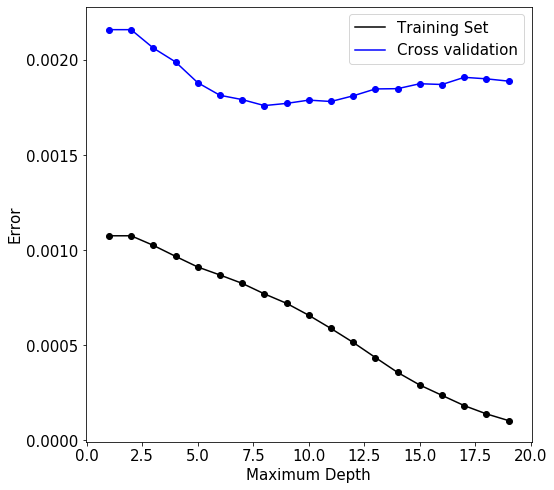

In [50]:
plt.plot(max_dep, err_t_dt, color='black', label='Training Set')
plt.scatter(max_dep, err_t_dt, color='black')
plt.plot(max_dep, err_val_dt, color='b', label='Cross validation')
plt.scatter(max_dep, err_val_dt, color='b')
plt.xlabel('Maximum Depth')
plt.ylabel('Error')
plt.legend()
plt.show()

In [51]:
best_max_dep = max_dep[err_val_dt == min(err_val_dt)][0]
print('The best maximum depth is:', best_max_dep)

The best maximum depth is: 8


Now we find the accuracy, confusion matrix, completeness and contamination.

In [53]:
dt = DecisionTreeClassifier(random_state=1, max_depth=best_max_dep)
dt.fit(xtrain, ytrain)

xtrain_pred_dt = dt.predict(xtrain) 
xtest_pred_dt = dt.predict(xtest)

In [54]:
#accuracy
accuracy_train_dt = accuracy_score(ytrain, xtrain_pred_dt)
accuracy_test_dt = accuracy_score(ytest, xtest_pred_dt)

print('The accuracy of the training set is:', accuracy_train_dt)
print('The accuracy of the test set is:', accuracy_test_dt)

#confusion matrix
confusion_train_dt = confusion_matrix(ytrain, xtrain_pred_dt)
confusion_test_dt = confusion_matrix(ytest, xtest_pred_dt)

print('\nThe confusion matrix of the training set is:\n', confusion_train_dt)
print('\nThe confusion matrix of the test set is:\n', confusion_test_dt)

completeness_test_dt, contamination_test_dt = completeness_contamination(xtest_pred_dt, ytest)
print('\nThe completeness for the test is:', completeness_test_dt)
print('The contamination for the test is:', contamination_test_dt)

completeness_train_dt, contamination_train_dt = completeness_contamination(xtrain_pred_dt, ytrain)
print('\nThe completeness for the train is:', completeness_train_dt)
print('The contamination for the train is:', contamination_train_dt)

The accuracy of the training set is: 0.9653285714285714
The accuracy of the test set is: 0.9578

The confusion matrix of the training set is:
 [[58877  1063]
 [ 1364  8696]]

The confusion matrix of the test set is:
 [[25136   542]
 [  724  3598]]

The completeness for the test is: 0.8324849606663581
The contamination for the test is: 0.13091787439613525

The completeness for the train is: 0.8644135188866799
The contamination for the train is: 0.10892509478430167


## Classification with Random Forest

In [6]:
#definition of the K-Foldings
kf = KFold(n_splits=5, shuffle=True, random_state=1)

N = np.linspace(15, 30, 15, dtype=int)

err_t = []
err_val = []

#Random Forest
for i in N:
    classif = RandomForestClassifier(i)
    error_train, error_validation = errors_cv(xtrain, ytrain, classif)
    
    err_t.append(error_train)
    err_val.append(error_validation)
    
print(err_t)    
print(len(err_t))

[0.00012111303541295122, 0.0001439688883624741, 0.00010101525445522108, 0.0001184508853698357, 9.44911182523068e-05, 9.780759955449395e-05, 8.563984863058427e-05, 9.616365727025899e-05, 7.57614408414158e-05, 8.375742428256125e-05, 6.681531047810609e-05, 8.375742428256125e-05, 6.185895741317419e-05, 6.43848442047141e-05, 6.681531047810609e-05]
15


[]

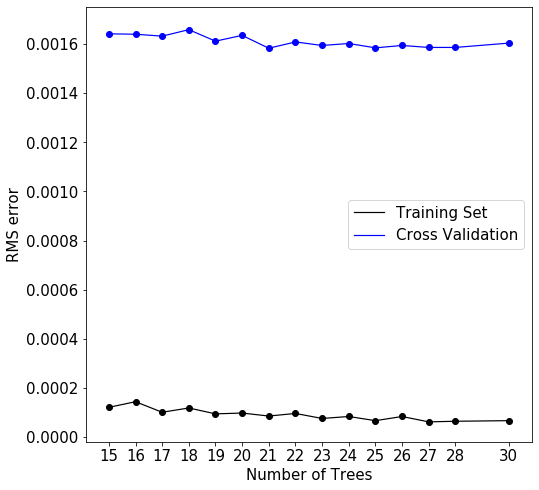

In [7]:
#plot
plt.plot(N, err_t, color='black', lw=1.2, label='Training Set')  
plt.scatter(N, err_t, color='black')
plt.plot(N, err_val, color='b', lw=1.2, label = 'Cross Validation')
plt.scatter(N, err_val, color='b')
plt.xlabel('Number of Trees')
plt.ylabel('RMS error')
plt.xticks(N)
plt.legend()
plt.plot()

Now we want to find the best number of trees in order to do a better classification of the data.


In [9]:
best_tree = N[err_val == min(err_val)][0]
print('The best number of trees is:', best_tree)

The best number of trees is: 21


In [10]:
ranfor = RandomForestClassifier(best_tree, random_state=10)
ranfor.fit(xtrain, ytrain)

xtrain_pred = ranfor.predict(xtrain) 
xtest_pred = ranfor.predict(xtest)

Now for the Random Forest Classifier we find the accuracy, the confusion matrix, the completeness and the contamination.

In [15]:
#accuracy
accuracy_train = accuracy_score(ytrain, xtrain_pred)
accuracy_test = accuracy_score(ytest, xtest_pred)

print('The accuracy of the training set is:', accuracy_train)
print('The accuracy of the test set is:', accuracy_test)

#confusion matrix
confusion_train = confusion_matrix(ytrain, xtrain_pred)
confusion_test = confusion_matrix(ytest, xtest_pred)

print('\nThe confusion matrix of the training set is:\n', confusion_train)
print('\nThe confusion matrix of the test set is:\n', confusion_test)

completeness_test, contamination_test = completeness_contamination(xtest_pred, ytest)
print('\nThe completeness for the test is:', completeness_test)
print('The contamination for the test is:', contamination_test)

completeness_train, contamination_train = completeness_contamination(xtrain_pred, ytrain)
print('\nThe completeness for the train is:', completeness_train)
print('The contamination for the train is:', contamination_train)

The accuracy of the training set is: 0.9996714285714285
The accuracy of the test set is: 0.9641666666666666

The confusion matrix of the training set is:
 [[59932     8]
 [   15 10045]]

The confusion matrix of the test set is:
 [[25279   399]
 [  676  3646]]

The completeness for the test is: 0.8435909301249421
The contamination for the test is: 0.09864029666254635

The completeness for the train is: 0.9985089463220675
The contamination for the train is: 0.0007957823535263105


## Comparison between the two classifications

In [55]:
classifiers = np.array(['Decision Tree', 'Random Forest'])


#accuracy
accuracy_train = np.array([round(float(accuracy_train_dt),3), round(float(accuracy_train),3)])
accuracy_test = np.array([round(float(accuracy_test_dt),3), round(float(accuracy_test),3)])

completeness_test = np.array([round(float(completeness_test_dt),3), round(float(completeness_test),3)])
completeness_train = np.array([round(float(completeness_train_dt),3), round(float(completeness_train),3)])
contamination_test = np.array([round(float(contamination_test_dt),3), round(float(contamination_test),3)])
contamination_train = np.array([round(float(contamination_train_dt),3), round(float(contamination_train),3)])

columns = ['Classifiers', 'AccuracyTrain', 'AccuracyTest', 'Complet_Train', 'Contam_Train']
lines = np.array([classifiers, accuracy_train, accuracy_test, 
                  completeness_train, contamination_test]).T

print(tabulate(lines, headers=columns, tablefmt='pretty'))

+---------------+---------------+--------------+---------------+--------------+
|  Classifiers  | AccuracyTrain | AccuracyTest | Complet_Train | Contam_Train |
+---------------+---------------+--------------+---------------+--------------+
| Decision Tree |     0.965     |    0.958     |     0.864     |    0.131     |
| Random Forest |      1.0      |    0.964     |     0.999     |    0.099     |
+---------------+---------------+--------------+---------------+--------------+


By observing the results we can say that the best classifier is the Random Forest. We can verify this through a ROC curve.

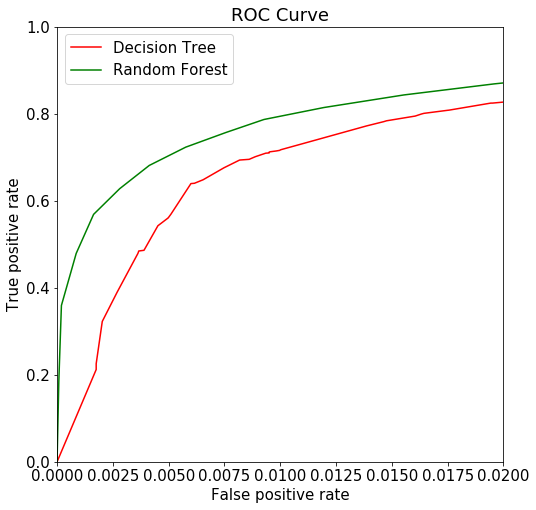

In [60]:
#Decision Tree
y_prob_dt = dt.predict_proba(xtest)[:, 1]
fpr_dt, tpr_dt, thresh_dt = roc_curve(ytest, y_prob_dt)

#Random Forest
y_prob_rf = ranfor.predict_proba(xtest)[:, 1]
fpr_rf, tpr_rf, thresh_rf = roc_curve(ytest, y_prob_rf)

#plot
plt.plot(fpr_dt, tpr_dt, label='Decision Tree', color='red')
plt.plot(fpr_rf, tpr_rf, label='Random Forest', color='green')
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0.0, 0.02)
plt.ylim(0.0, 1)
plt.legend()
plt.show()

The better classifier is the Random Forest.

## Classification of Random Forest for only: total mass, mass ratio and redshift

In [24]:
#downsize the dataset
M = int(1e5)
X_1 = [] 

for i in ['mtot', 'q', 'z']:
    X_1.append(data[i][:M])
    
X_1 = np.array(X_1).T
det = det[:M]   
det = np.array(det)

xtrain_1, xtest_1, ytrain_1, ytest_1 = train_test_split(X_1, det, test_size=0.3, random_state=42)

In [25]:
#definition of the K-Foldings
kf = KFold(n_splits=5, shuffle=True, random_state=1)

N = np.linspace(15, 30, 15, dtype=int)

err_t_1 = []
err_val_1 = []

#Random Forest
for i in N:
    classif_1 = RandomForestClassifier(i)
    error_train_1, error_validation_1 = errors_cv(xtrain_1, ytrain_1, classif_1)
    
    err_t_1.append(error_train_1)
    err_val_1.append(error_validation_1)

[]

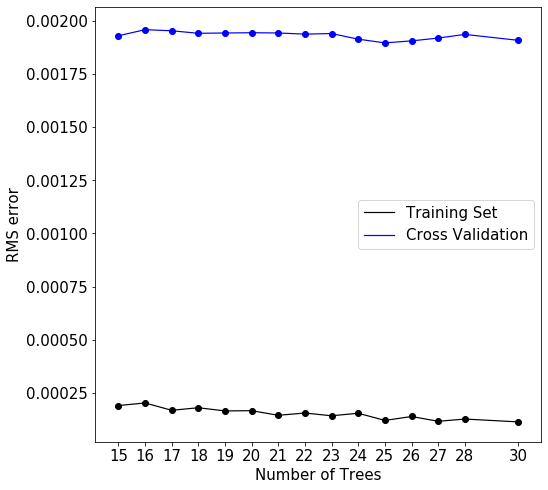

In [26]:
#plot
plt.plot(N, err_t_1, color='black', lw=1.2, label='Training Set')  
plt.scatter(N, err_t_1, color='black')
plt.plot(N, err_val_1, color='b', lw=1.2, label = 'Cross Validation')
plt.scatter(N, err_val_1, color='b')
plt.xlabel('Number of Trees')
plt.ylabel('RMS error')
plt.xticks(N)
plt.legend()
plt.plot()

Now we want to find the best number of trees.

In [30]:
best_tree_1 = N[err_val_1 == min(err_val_1)][0]
print('The best number of trees is:', best_tree_1)

The best number of trees is: 25


In [31]:
ranfor_1 = RandomForestClassifier(best_tree_1, random_state=10)
ranfor_1.fit(xtrain_1, ytrain_1)

xtrain_pred_1 = ranfor_1.predict(xtrain_1) 
xtest_pred_1 = ranfor_1.predict(xtest_1)

In [32]:
#accuracy
accuracy_train_1 = accuracy_score(ytrain_1, xtrain_pred_1)
accuracy_test_1 = accuracy_score(ytest_1, xtest_pred_1)

print('The accuracy of the training set is:', accuracy_train_1)
print('The accuracy of the test set is:', accuracy_test_1)

#confusion matrix
confusion_train_1 = confusion_matrix(ytrain_1, xtrain_pred_1)
confusion_test_1 = confusion_matrix(ytest_1, xtest_pred_1)

print('\nThe confusion matrix of the training set is:\n', confusion_train_1)
print('\nThe confusion matrix of the test set is:\n', confusion_test_1)

completeness_test_1, contamination_test_1 = completeness_contamination(xtest_pred_1, ytest_1)
print('\nThe completeness for the test is:', completeness_test_1)
print('The contamination for the test is:', contamination_test_1)

completeness_train_1, contamination_train_1 = completeness_contamination(xtrain_pred_1, ytrain_1)
print('\nThe completeness for the train is:', completeness_train_1)
print('The contamination for the train is:', contamination_train_1)

The accuracy of the training set is: 0.9991428571428571
The accuracy of the test set is: 0.9477

The confusion matrix of the training set is:
 [[59922    18]
 [   42 10018]]

The confusion matrix of the test set is:
 [[25006   672]
 [  897  3425]]

The completeness for the test is: 0.7924571957427117
The contamination for the test is: 0.16402245545521113

The completeness for the train is: 0.9958250497017893
The contamination for the train is: 0.0017935432443204463


We compare the two results.

In [46]:
classifiers = np.array(['Random Forest \n for all components', 'Random Forest \n for total mass, mass ratio and z'])


#accuracy
accuracy_train_tot = np.array([round(float(accuracy_train),3), round(float(accuracy_train_1),3)])
accuracy_test_tot = np.array([round(float(accuracy_test),3), round(float(accuracy_test_1),3)])

completeness_test_tot = np.array([round(float(completeness_test),3), round(float(completeness_test_1),3)])
completeness_train_tot = np.array([round(float(completeness_train),3), round(float(completeness_train_1),3)])
contamination_test_tot = np.array([round(float(contamination_test),3), round(float(contamination_test_1),3)])
contamination_train_tot = np.array([round(float(contamination_train),3), round(float(contamination_train_1),3)])

columns = ['Classifiers', 'AccuracyTrain', 'AccuracyTest', 'Complet_Train', 'Contam_Train']
lines = np.array([classifiers, accuracy_train_tot, accuracy_test_tot, 
                  completeness_train_tot, contamination_test_tot]).T

print(tabulate(lines, headers=columns, tablefmt='pretty'))

+-----------------------------------+---------------+--------------+---------------+--------------+
|            Classifiers            | AccuracyTrain | AccuracyTest | Complet_Train | Contam_Train |
+-----------------------------------+---------------+--------------+---------------+--------------+
|          Random Forest            |      1.0      |    0.964     |     0.999     |    0.099     |
|         for all components        |               |              |               |              |
|          Random Forest            |     0.999     |    0.948     |     0.996     |    0.164     |
|  for total mass, mass ratio and z |               |              |               |              |
+-----------------------------------+---------------+--------------+---------------+--------------+


We get almost the same results for both implementations.